## Trade-of: number of words that are represented (usable words) vs. quality of w2v model 

Min_count refers to the number of times a word has to appear in the underlying training corpus in order to get an associated word vector when training Word2vec. A word vector is created by taking the surrounding words into account. If a word appears more often in the corpus, more contexts can be used in order to create the word vector. Therefore, the word vector will be more representative when min_count is high. On the other hand, if min_count is low, less contexts can be taken for the word vector creation. The word vectors will then be less representative. The problem of a high min_count set up is that a lot of words don’t get a word vector because they appear not often enough in the training corpus. Since we have already existing experimental sentences, we have to ensure that all relevant words have an associated word vector. Otherwise, we can not do any calculations with these words. If a word is not present in the underlying training corpus (or does not appear as often as the min_count set up) Word2vec can not create a word vector for this word. Without a word vector, no calculations can be done. The goal of this project is to find the highest min_count set up that at the same time includes all (or almost all) relevant words.

First of all, we import all relevant libraries

In [1]:
import pandas as pd

from gensim.models.word2vec import Text8Corpus
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

In [2]:
#upload of the Word2vec model
w2v_model = Word2Vec(
    Text8Corpus(r'text8'),
    size=100,
    window=5,
    min_count=5,#5 is the default value here, we will change this later in order to see which value is the best
    workers=3)

In [4]:
#upload the relevant items of the Vasishth et al. (2010) study
df = pd.read_csv('vasishth_2010_Eng2.csv', sep=';')

In [5]:
df

,num,w1eng,w2eng,w3eng,w2eng_i
0,1,carpenter,craftsman,peasant,pillar
1,2,mother,daughter,sister,gun
2,3,worker,tenant,foreman,bucket
3,4,trader,businessman,professor,computer
4,5,painter,musician,father,hut
5,6,saxophonist,trumpeter,conductor,baton
6,7,pharmacist,optician,stranger,button
7,8,cleaner,janitor,doctor,ball
8,9,dancer,singer,bystander,shoe
9,10,artist,sportsman,guard,computer


We now store all words of our model that have an associated word vector (for the specific min_count setup) in the variable “word_dict”.

In [6]:
word_dict = w2v_model.wv.vocab

We now create a function that iterates over the different columns with the different words and checks if the words are represented in “word_dict”. Or in other words, if a specific experimental word has an associated word vector with this specific min_count setup. 
If a word has an associated vector, a TRUE is written in a new column in the same row as the word. When this is not the case a FALSE appears in that column. 

In [7]:
df['w1eng_inW2V'] = df.w1eng.apply(lambda x: x in word_dict)
df['w2eng_inW2V'] = df.w2eng.apply(lambda x: x in word_dict)
df['w3eng_inW2V'] = df.w3eng.apply(lambda x: x in word_dict)
df['w2eng_i_inW2V'] = df.w2eng_i.apply(lambda x: x in word_dict)

In [8]:
df

,num,w1eng,w2eng,w3eng,w2eng_i,w1eng_inW2V,w2eng_inW2V,w3eng_inW2V,w2eng_i_inW2V
0,1,carpenter,craftsman,peasant,pillar,True,True,True,True
1,2,mother,daughter,sister,gun,True,True,True,True
2,3,worker,tenant,foreman,bucket,True,True,True,True
3,4,trader,businessman,professor,computer,True,True,True,True
4,5,painter,musician,father,hut,True,True,True,True
5,6,saxophonist,trumpeter,conductor,baton,True,True,True,True
6,7,pharmacist,optician,stranger,button,True,True,True,True
7,8,cleaner,janitor,doctor,ball,True,True,True,True
8,9,dancer,singer,bystander,shoe,True,True,True,True
9,10,artist,sportsman,guard,computer,True,True,True,True


We can see that with a min_count setup of five, the word "walking stick" is not represented by a vector. We will now test different min_count set ups and corresponding missing vectors.
To do that, we will exchange min_count by different numbers. We start with the number one and increase it exponentially (which means that we double it each time) until 1024. 

In [12]:
min_count_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


def get_num_words_out(min_count: int) -> int:   
    # train the model for each min_count entry
    w2v_model = Word2Vec(
        Text8Corpus(r'text8'),
        size=100,
        window=5,
        min_count=min_count,
        workers=3)
    word_dict = w2v_model.wv.vocab
    
    # upload the data frame and create the TRUE/FALSE entries for each entry
    df = pd.read_csv('vasishth_2010_Eng2.csv', sep=';')
    
    df['w1eng_inW2V'] = df.w1eng.apply(lambda x: x not in word_dict)
    df['w2eng_inW2V'] = df.w2eng.apply(lambda x: x not in word_dict)
    df['w3eng_inW2V'] = df.w3eng.apply(lambda x: x not in word_dict)
    df['w2eng_i_inW2V'] = df.w2eng_i.apply(lambda x: x not in word_dict)

    #count the sum of words that are not represented in the model for each min_count entry    
    w1eng_inW2V_count = df.w1eng_inW2V.sum()
    w2eng_inW2V_count = df.w2eng_inW2V.sum()
    w3eng_inW2V_count = df.w3eng_inW2V.sum()
    w2eng_i_inW2V_count = df.w2eng_i_inW2V.sum()
    
    number_of_unknown_words = w1eng_inW2V_count + w2eng_inW2V_count + w3eng_inW2V_count + w2eng_i_inW2V_count
    
    return number_of_unknown_words
unknown_words_list = []


In [13]:
for min_count in min_count_list:
    x = get_num_words_out(min_count)
    unknown_words_list.append(x)

In [14]:
unknown_words_list

[1, 1, 1, 3, 5, 11, 20, 25, 33, 39, 47]

We will now graphically show how many words are missing with the different min_count setups.

Text(0, 0.5, 'num_words_out')

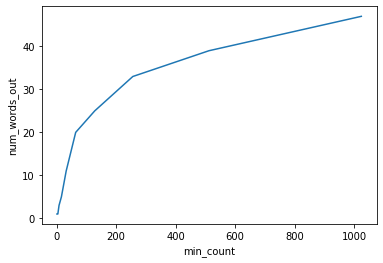

In [15]:
plt.plot(min_count_list, unknown_words_list)
plt.xlabel('min_count')
plt.ylabel('num_words_out')

We can see that even with min_count 1 one word is missing. This is the word "walking stick". Starting by min_count 8 the number of missing words increases dramatically. We examined the region around min_count 4 to see how many words are missing between the min_count set ups between 4 and 8. The highest min_count value for which only walking stick was missing is 5. Therefore, 5 is taken as min_count value for all further analyses.

We interchanged the word "walking stick" with a synonym "cane" that was present in the training corpus.

In [9]:
df2 = pd.read_csv('vasishth_2010_Eng.csv', sep=';')
df2

,num,w1eng,w2eng,w3eng,w2eng_i
0,1,carpenter,craftsman,peasant,pillar
1,2,mother,daughter,sister,gun
2,3,worker,tenant,foreman,bucket
3,4,trader,businessman,professor,computer
4,5,painter,musician,father,hut
5,6,saxophonist,trumpeter,conductor,baton
6,7,pharmacist,optician,stranger,button
7,8,cleaner,janitor,doctor,ball
8,9,dancer,singer,bystander,shoe
9,10,artist,sportsman,guard,computer


In [12]:
df2['w1eng_inW2V'] = df2.w1eng.apply(lambda x: x in word_dict)
df2['w2eng_inW2V'] = df2.w2eng.apply(lambda x: x in word_dict)
df2['w3eng_inW2V'] = df2.w3eng.apply(lambda x: x in word_dict)
df2['w2eng_i_inW2V'] = df2.w2eng_i.apply(lambda x: x in word_dict)

In [13]:
df2

,num,w1eng,w2eng,w3eng,w2eng_i,w1eng_inW2V,w2eng_inW2V,w3eng_inW2V,w2eng_i_inW2V
0,1,carpenter,craftsman,peasant,pillar,True,True,True,True
1,2,mother,daughter,sister,gun,True,True,True,True
2,3,worker,tenant,foreman,bucket,True,True,True,True
3,4,trader,businessman,professor,computer,True,True,True,True
4,5,painter,musician,father,hut,True,True,True,True
5,6,saxophonist,trumpeter,conductor,baton,True,True,True,True
6,7,pharmacist,optician,stranger,button,True,True,True,True
7,8,cleaner,janitor,doctor,ball,True,True,True,True
8,9,dancer,singer,bystander,shoe,True,True,True,True
9,10,artist,sportsman,guard,computer,True,True,True,True


Now, all relevant words are represented as word vectors.